## Function

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_distribution
from math import gcd
from numpy.random import randint
from numpy import pi

In [2]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

In [3]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

In [4]:
def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [5]:
qc = QuantumCircuit(3, 3)

qc.x(1)

qc.barrier()
qft(qc,3)
qc.barrier()
qc.measure(range(3), range(3))
qc.draw()

░                                      ┌───┐    ░ ┌─┐      
q_0: ──────░───────■──────────────────────■───────┤ H ├─X──░─┤M├──────
     ┌───┐ ░       │                ┌───┐ │P(π/2) └───┘ │  ░ └╥┘┌─┐   
q_1: ┤ X ├─░───────┼────────■───────┤ H ├─■─────────────┼──░──╫─┤M├───
     └───┘ ░ ┌───┐ │P(π/4)  │P(π/2) └───┘               │  ░  ║ └╥┘┌─┐
q_2: ──────░─┤ H ├─■────────■───────────────────────────X──░──╫──╫─┤M├
           ░ └───┘                                         ░  ║  ║ └╥┘
c: 3/═════════════════════════════════════════════════════════╩══╩══╩═
                                                              0  1  2

In [6]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

In [7]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(5π/4) ├
     ├───┤├─────────┤
q_1: ┤ H ├┤ P(5π/2) ├
     ├───┤└┬───────┬┘
q_2: ┤ H ├─┤ P(5π) ├─
     └───┘ └───────┘

In [8]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

┌─────────┐┌─────────────┐   ┌───┐                                   »
   q_0: ┤ U2(0,π) ├┤ U(0,0,5π/4) ├─X─┤ H ├─■────────────────────────■────────»
        ├─────────┤├─────────────┤ │ └───┘ │P(-π/2) ┌───┐           │        »
   q_1: ┤ U2(0,π) ├┤ U(0,0,5π/2) ├─┼───────■────────┤ H ├─■─────────┼────────»
        ├─────────┤└┬───────────┬┘ │                └───┘ │P(-π/2)  │P(-π/4) »
   q_2: ┤ U2(0,π) ├─┤ U(0,0,5π) ├──X──────────────────────■─────────■────────»
        └─────────┘ └───────────┘                                            »
meas: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«              ░ ┌─┐      
«   q_0: ──────░─┤M├──────
«              ░ └╥┘┌─┐   
«   q_1: ──────░──╫─┤M├───
«        ┌───┐ ░  ║ └╥┘┌─┐
«   q_2: ┤ H ├─░──╫──╫─┤M├
«        └───┘ ░  ║  ║ └╥┘
«meas: 3/═════════╩══╩══╩═
«                 0  1  2

{'101': 1024}


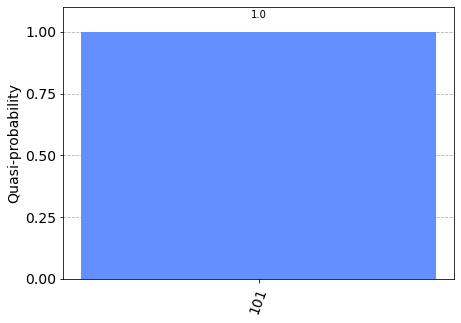

In [9]:
aer_sim = Aer.get_backend('aer_simulator')
qc_transpiled = transpile(qc, aer_sim, optimization_level=0)

results = aer_sim.run(qc_transpiled).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

## Simulation on Quantum Devices (Q1 Code)

In [11]:
provider = IBMProvider()
provider.backends(min_num_qubits=5, simulator=False, operational=True)

[<IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_lima')>]

Circuit Depth : 29
{'000': 64, '001': 294, '010': 57, '011': 176, '100': 373, '101': 2630, '110': 176, '111': 230}


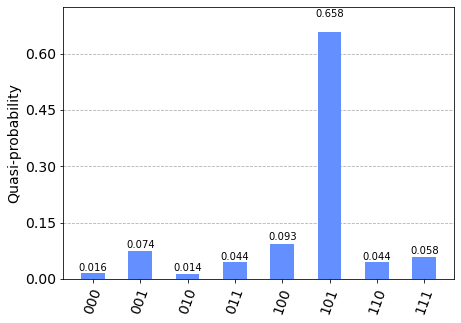

In [17]:
backend = provider.get_backend('ibmq_quito')
qc_quito = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4])

print("Circuit Depth :", qc_quito.depth())
results = backend.run(qc_quito).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 29
{'000': 180, '001': 319, '010': 82, '011': 160, '100': 574, '101': 2358, '110': 141, '111': 186}


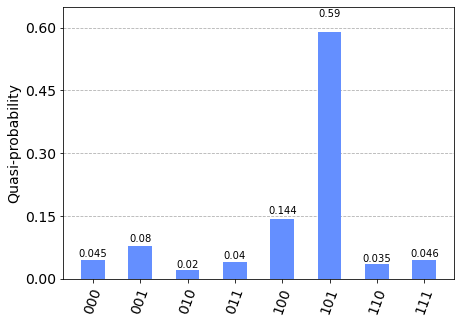

In [20]:
backend = provider.get_backend('ibmq_lima')
qc_lima = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4])

print("Circuit Depth :", qc_lima.depth())
results = backend.run(qc_lima).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 29
{'000': 137, '001': 435, '010': 106, '011': 156, '100': 415, '101': 2421, '110': 147, '111': 183}


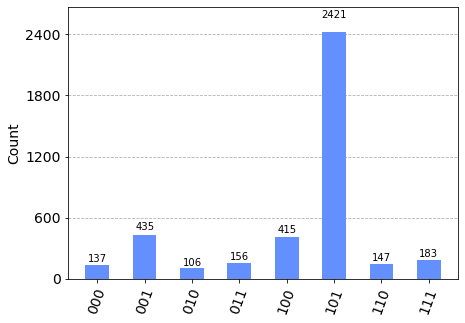

In [21]:
backend = provider.get_backend('ibmq_belem')
qc_belem = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4])

print("Circuit Depth :", qc_belem.depth())
results = backend.run(qc_belem).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 29
{'000': 141, '001': 393, '010': 31, '011': 139, '100': 231, '101': 2937, '110': 35, '111': 93}


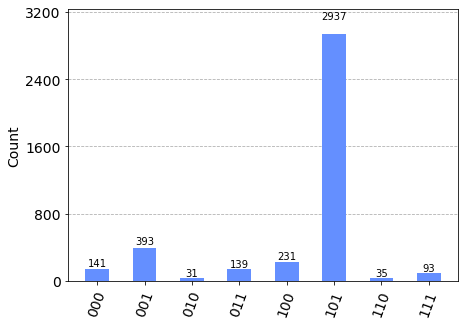

In [22]:
backend = provider.get_backend('ibm_nairobi')
qc_nairobi = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5])

print("Circuit Depth :", qc_nairobi.depth())
results = backend.run(qc_nairobi).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 29
{'000': 46, '001': 329, '010': 45, '011': 246, '100': 200, '101': 2858, '110': 93, '111': 183}


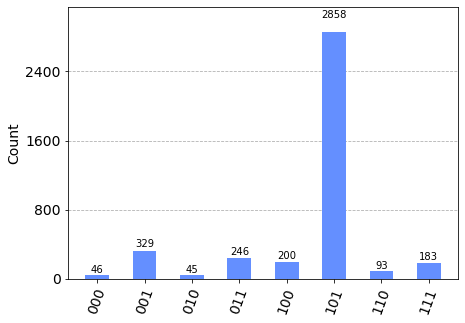

In [23]:
backend = provider.get_backend('ibm_perth')
qc_perth = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5])

print("Circuit Depth :", qc_perth.depth())
results = backend.run(qc_perth).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 29


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\qiskit_ibm_provider\ibm_backend.py:437: UserWarning: The backend ibm_lagos is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


{'000': 37, '001': 212, '010': 23, '011': 297, '100': 62, '101': 2945, '110': 71, '111': 353}


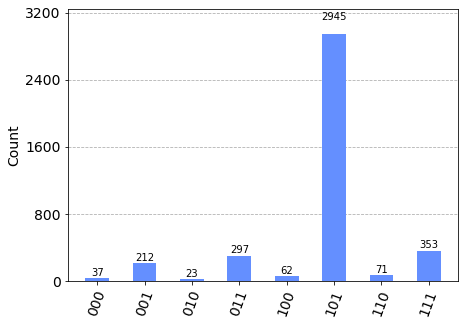

In [12]:
backend = provider.get_backend('ibm_lagos')
qc_lagos = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5])

print("Circuit Depth :", qc_lagos.depth())
results = backend.run(qc_lagos).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 29
{'000': 40, '001': 264, '010': 29, '011': 181, '100': 165, '101': 3004, '110': 74, '111': 243}


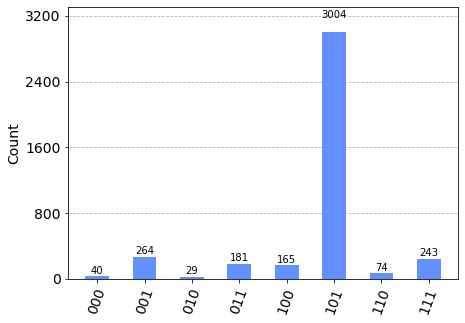

In [14]:
backend = provider.get_backend('ibmq_manila')
qc_manila = transpile(qc, backend, optimization_level=2, initial_layout=[2,3,4])

print("Circuit Depth :", qc_manila.depth())
results = backend.run(qc_manila).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 29
{'000': 66, '001': 335, '010': 44, '011': 164, '100': 328, '101': 2825, '110': 53, '111': 185}


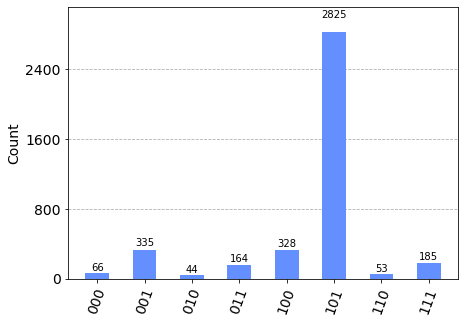

In [15]:
backend = provider.get_backend('ibmq_jakarta')
qc_jakarta = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5])

print("Circuit Depth :", qc_jakarta.depth())
results = backend.run(qc_jakarta).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

## Simulation on Quantum Devices (Q2 Code / partially SWAP)

In [59]:
qc = QuantumCircuit(5)

number = 5
qc.h([0,3,4])
qc.p(number*pi/4,0)
qc.p(number*pi/2,3)
qc.p(number*pi,4)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(5π/4) ├
     └───┘└─────────┘
q_1: ────────────────
                     
q_2: ────────────────
     ┌───┐┌─────────┐
q_3: ┤ H ├┤ P(5π/2) ├
     ├───┤└┬───────┬┘
q_4: ┤ H ├─┤ P(5π) ├─
     └───┘ └───────┘

In [60]:
# Encode
qc.cx(0,1)

# CCX_L
qc.csx(0,4)
qc.cx(1,0)
qc.csx(0,4)
qc.cx(1,0)
qc.csx(0,4)

# CXX_L
qc.cx(0,1)
qc.cx(4,0)
qc.cx(0,1)

# CCX_L
qc.csx(0,4)
qc.cx(1,0)
qc.csx(0,4)
qc.cx(1,0)
qc.csx(0,4)

# EF
qc.cx(0,2)
qc.cx(1,2)
qc.cx(0,1)

# Last of parts
qc.h(0)
qc.cp(-pi/2, 0, 3)
qc.h(3)
qc.cp(-pi/4, 0, 4)
qc.cp(-pi/2, 3, 4)
qc.h(4)

qc.measure_all()
qc.draw()

┌───┐┌─────────┐           ┌───┐      ┌───┐           ┌───┐           »
   q_0: ┤ H ├┤ P(5π/4) ├──■────■───┤ X ├──■───┤ X ├──■─────■──┤ X ├──■────■───»
        └───┘└─────────┘┌─┴─┐  │   └─┬─┘  │   └─┬─┘  │   ┌─┴─┐└─┬─┘┌─┴─┐  │   »
   q_1: ────────────────┤ X ├──┼─────■────┼─────■────┼───┤ X ├──┼──┤ X ├──┼───»
                        └───┘  │          │          │   └───┘  │  └───┘  │   »
   q_2: ───────────────────────┼──────────┼──────────┼──────────┼─────────┼───»
        ┌───┐┌─────────┐       │          │          │          │         │   »
   q_3: ┤ H ├┤ P(5π/2) ├───────┼──────────┼──────────┼──────────┼─────────┼───»
        ├───┤└┬───────┬┘     ┌─┴──┐     ┌─┴──┐     ┌─┴──┐       │       ┌─┴──┐»
   q_4: ┤ H ├─┤ P(5π) ├──────┤ Sx ├─────┤ Sx ├─────┤ Sx ├───────■───────┤ Sx ├»
        └───┘ └───────┘      └────┘     └────┘     └────┘               └────┘»
meas: 5/══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ┌───┐      ┌───┐                     ┌───┐                         »
«   q_0: ┤ X ├──■───┤ X ├──■─────■─────────■──┤ H ├─■──────────────■────────»
«        └─┬─┘  │   └─┬─┘  │     │       ┌─┴─┐└───┘ │              │        »
«   q_1: ──■────┼─────■────┼─────┼────■──┤ X ├──────┼──────────────┼────────»
«               │          │   ┌─┴─┐┌─┴─┐└───┘      │              │        »
«   q_2: ───────┼──────────┼───┤ X ├┤ X ├───────────┼──────────────┼────────»
«               │          │   └───┘└───┘           │P(-π/2) ┌───┐ │        »
«   q_3: ───────┼──────────┼────────────────────────■────────┤ H ├─┼────────»
«             ┌─┴──┐     ┌─┴──┐                              └───┘ │P(-π/4) »
«   q_4: ─────┤ Sx ├─────┤ Sx ├────────────────────────────────────■────────»
«             └────┘     └────┘                                             »
«meas: 5/═══════════════════════════════════════════════════════════════════»
«                                                                           »
«                        ░ ┌─┐            
«   q_0: ────────────────░─┤M├────────────
«                        ░ └╥┘┌─┐         
«   q_1: ────────────────░──╫─┤M├─────────
«                        ░  ║ └╥┘┌─┐      
«   q_2: ────────────────░──╫──╫─┤M├──────
«                        ░  ║  ║ └╥┘┌─┐   
«   q_3: ─■──────────────░──╫──╫──╫─┤M├───
«         │P(-π/2) ┌───┐ ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ─■────────┤ H ├─░──╫──╫──╫──╫─┤M├
«                  └───┘ ░  ║  ║  ║  ║ └╥┘
«meas: 5/═══════════════════╩══╩══╩══╩══╩═
«                           0  1  2  3  4

{'10001': 1024}


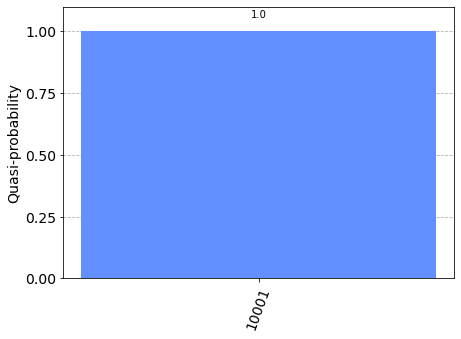

In [61]:
aer_sim = Aer.get_backend('aer_simulator')
qc_transpiled = transpile(qc, aer_sim, optimization_level=0)

results = aer_sim.run(qc_transpiled).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

In [62]:
provider = IBMProvider()
provider.backends(min_num_qubits=5, simulator=False, operational=True)

[<IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibmq_jakarta')>]

Circuit Depth : 59
{'00000': 111, '00001': 386, '10000': 327, '10001': 1992, '10010': 47, '10011': 90, '10100': 31, '10101': 81, '10110': 51, '10111': 166, '11000': 150, '11001': 65, '11010': 41, '11011': 4, '11100': 11, '11101': 3, '11110': 38, '11111': 9, '00010': 13, '00011': 23, '00100': 15, '00101': 21, '00110': 29, '00111': 65, '01000': 91, '01001': 50, '01010': 27, '01011': 2, '01100': 9, '01110': 41, '01111': 11}


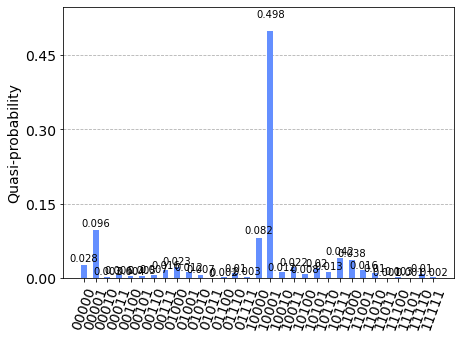

In [63]:
backend = provider.get_backend('ibmq_quito')
qc_quito = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4,0,2])

print("Circuit Depth :", qc_quito.depth())
results = backend.run(qc_quito).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 59
{'00000': 265, '00001': 624, '10000': 423, '10001': 1358, '10010': 47, '10011': 151, '10100': 17, '10101': 33, '10110': 46, '10111': 75, '11000': 254, '11001': 72, '11010': 41, '11011': 3, '11100': 10, '11101': 5, '11110': 21, '11111': 7, '00010': 46, '00011': 71, '00100': 24, '00101': 34, '00110': 47, '00111': 76, '01000': 143, '01001': 34, '01010': 23, '01011': 3, '01100': 5, '01101': 1, '01110': 35, '01111': 6}


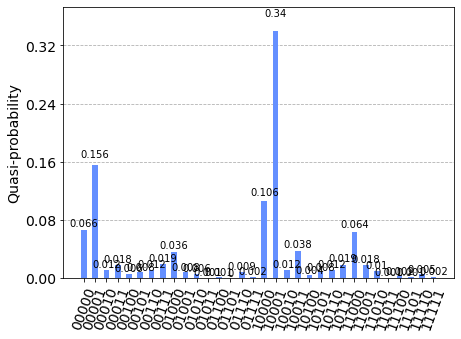

In [64]:
backend = provider.get_backend('ibmq_lima')
qc_lima = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4,0,2])

print("Circuit Depth :", qc_lima.depth())
results = backend.run(qc_lima).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 59
{'00000': 271, '00001': 574, '10000': 399, '10001': 1329, '10010': 22, '10011': 62, '10100': 23, '10101': 46, '10110': 39, '10111': 98, '11000': 345, '11001': 50, '11010': 35, '11011': 1, '11100': 30, '11101': 2, '11110': 43, '11111': 13, '00010': 29, '00011': 35, '00100': 25, '00101': 38, '00110': 53, '00111': 115, '01000': 181, '01001': 47, '01010': 22, '01011': 3, '01100': 15, '01101': 8, '01110': 35, '01111': 12}


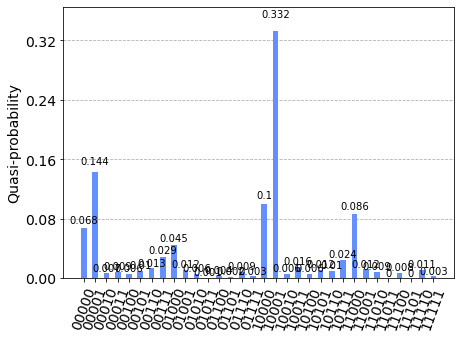

In [65]:
backend = provider.get_backend('ibmq_belem')
qc_belem = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4,0,2])

print("Circuit Depth :", qc_belem.depth())
results = backend.run(qc_belem).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 59
{'00000': 434, '00001': 602, '10000': 301, '10001': 690, '10010': 40, '10011': 61, '10100': 28, '10101': 52, '10110': 53, '10111': 106, '11000': 265, '11001': 47, '11010': 42, '11011': 8, '11100': 33, '11101': 7, '11110': 50, '11111': 12, '00010': 36, '00011': 70, '00100': 56, '00101': 82, '00110': 83, '00111': 126, '01000': 429, '01001': 68, '01010': 40, '01011': 11, '01100': 49, '01101': 10, '01110': 94, '01111': 15}


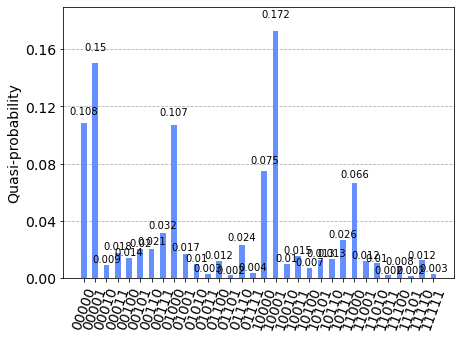

In [66]:
backend = provider.get_backend('ibm_nairobi')
qc_nairobi = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5,0,2])

print("Circuit Depth :", qc_nairobi.depth())
results = backend.run(qc_nairobi).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 59
{'00000': 88, '00001': 531, '10000': 337, '10001': 1832, '10010': 37, '10011': 48, '10100': 26, '10101': 59, '10110': 67, '10111': 88, '11000': 167, '11001': 61, '11010': 38, '11011': 6, '11100': 39, '11101': 16, '11110': 65, '11111': 8, '00010': 11, '00011': 25, '00100': 20, '00101': 33, '00110': 26, '00111': 57, '01000': 101, '01001': 86, '01010': 23, '01011': 15, '01100': 20, '01101': 10, '01110': 45, '01111': 15}


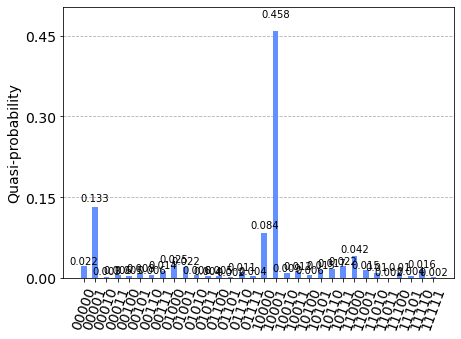

In [67]:
backend = provider.get_backend('ibm_perth')
qc_perth = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5,0,2])

print("Circuit Depth :", qc_perth.depth())
results = backend.run(qc_perth).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 59
{'00000': 472, '00001': 934, '10000': 393, '10001': 546, '10010': 8, '10011': 20, '10100': 24, '10101': 22, '10110': 48, '10111': 81, '11000': 419, '11001': 124, '11010': 14, '11011': 2, '11100': 24, '11101': 6, '11110': 44, '11111': 17, '00010': 11, '00011': 20, '00100': 27, '00101': 38, '00110': 77, '00111': 159, '01000': 301, '01001': 71, '01010': 18, '01011': 2, '01100': 25, '01110': 40, '01111': 13}


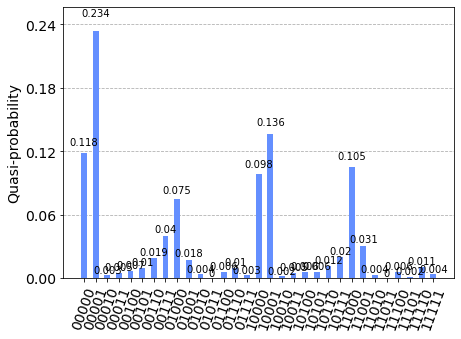

In [68]:
backend = provider.get_backend('ibm_lagos')
qc_lagos = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5,0,2])

print("Circuit Depth :", qc_lagos.depth())
results = backend.run(qc_lagos).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)

Circuit Depth : 59
{'00000': 249, '00001': 557, '10000': 278, '10001': 1327, '10010': 30, '10011': 78, '10100': 16, '10101': 53, '10110': 45, '10111': 101, '11000': 419, '11001': 73, '11010': 66, '11011': 6, '11100': 25, '11101': 12, '11110': 45, '11111': 8, '00010': 38, '00011': 52, '00100': 15, '00101': 27, '00110': 63, '00111': 79, '01000': 136, '01001': 39, '01010': 31, '01011': 10, '01100': 20, '01101': 11, '01110': 84, '01111': 7}


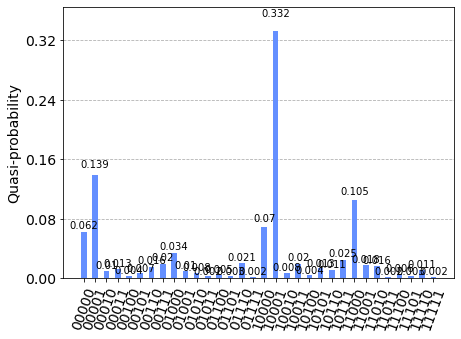

In [69]:
backend = provider.get_backend('ibmq_jakarta')
qc_jakarta = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5,0,2])

print("Circuit Depth :", qc_jakarta.depth())
results = backend.run(qc_jakarta).result()
counts = results.get_counts()
print(counts)
plot_distribution(counts)